In [1]:
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Use relative path for dataset
dataset_path = 'PlantVillage'

# Get available classes from the directory
available_classes = [d for d in os.listdir(dataset_path) 
                    if os.path.isdir(os.path.join(dataset_path, d))]
print("Available classes:", available_classes)

selected_classes = ['Pepper__bell___Bacterial_spot', 
                   'Potato___Late_blight', 
                   'Tomato_Late_blight']

# Verify selected classes exist
selected_classes = [c for c in selected_classes if c in available_classes]
if not selected_classes:
    raise ValueError("None of the selected classes found in dataset")

print("\nUsing classes:", selected_classes)

data = []
labels = []

# Iterate through the dataset directory
for class_name in os.listdir(dataset_path):
    if class_name in selected_classes:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):  # Verify it's a directory
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):  # Verify it's a file
                    data.append(img_path)
                    labels.append(class_name)

df = pd.DataFrame({'data': data, 'label': labels})
df

Available classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']

Using classes: ['Pepper__bell___Bacterial_spot', 'Potato___Late_blight', 'Tomato_Late_blight']


,data,label
0,PlantVillage\Pepper__bell___Bacterial_spot\002...,Pepper__bell___Bacterial_spot
1,PlantVillage\Pepper__bell___Bacterial_spot\006...,Pepper__bell___Bacterial_spot
2,PlantVillage\Pepper__bell___Bacterial_spot\00f...,Pepper__bell___Bacterial_spot
3,PlantVillage\Pepper__bell___Bacterial_spot\016...,Pepper__bell___Bacterial_spot
4,PlantVillage\Pepper__bell___Bacterial_spot\016...,Pepper__bell___Bacterial_spot
...,...,...
3901,PlantVillage\Tomato_Late_blight\ff03c1b7-ae44-...,Tomato_Late_blight
3902,PlantVillage\Tomato_Late_blight\ff3ddd95-9c84-...,Tomato_Late_blight
3903,PlantVillage\Tomato_Late_blight\ff735d59-0023-...,Tomato_Late_blight
3904,PlantVillage\Tomato_Late_blight\ff82087d-e992-...,Tomato_Late_blight


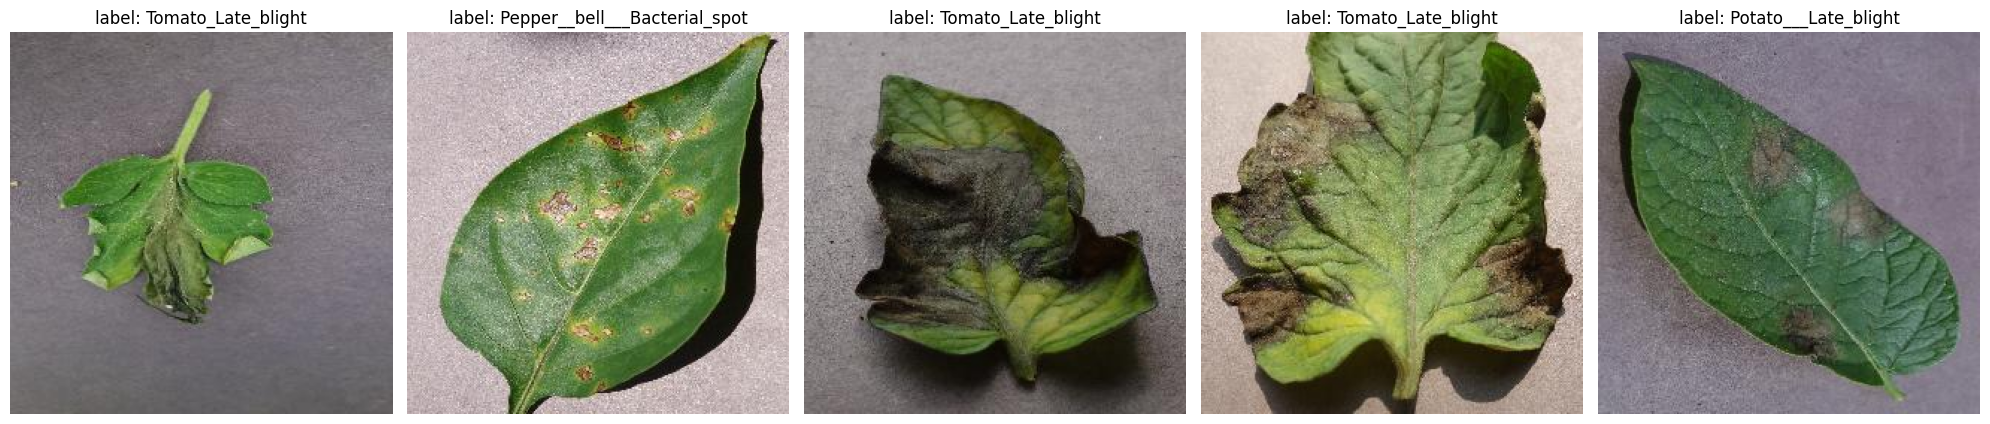

In [3]:
# Display sample images
plt.figure(figsize=(20, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    index = np.random.choice(df.index)
    filename = df.loc[index, 'data']
    category = df.loc[index, 'label']
    img = Image.open(filename)
    plt.imshow(img)
    plt.title(f'label: {category}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
def extract_hog_features(image):
    # Convert the image to grayscale using cv2
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hog = cv2.HOGDescriptor()
    
    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features.flatten()

In [5]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
batch_size = 32  # Adjust batch size based on memory constraints
features_list = []
labels_list = []

# Resize function to downsample images
def resize_image(image, new_size=(128, 128)):
    return cv2.resize(image, new_size)

for start in range(0, len(df_shuffled), batch_size):
    end = min(start + batch_size, len(df_shuffled))
    batch = df_shuffled[start:end]

    batch_features = []
    batch_labels = []

    for index, row in batch.iterrows():
        try:
            image = cv2.imread(row['data'])
            if image is None:
                print(f"Warning: Could not read image {row['data']}")
                continue
            resized_image = resize_image(image)  # Resize image to smaller dimensions
            hog_features = extract_hog_features(resized_image)
            batch_features.append(hog_features)
            batch_labels.append(row['label'])
        except Exception as e:
            print(f"Error processing {row['data']}: {str(e)}")
            continue

    features_list.extend(batch_features)
    labels_list.extend(batch_labels)

In [6]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

print("Shape of extracted HOG features:", features_array.shape)

Shape of extracted HOG features: (3906, 34020)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    features_array, 
    labels_encoded, 
    test_size=0.25, 
    random_state=42, 
    stratify=labels_encoded
)

In [8]:
lr_pipeline = Pipeline([
    ('pca', PCA(n_components=2100, random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=2100, random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [9]:
predictions = lr_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8782


In [10]:
report = classification_report(y_test, predictions, output_dict=True, zero_division=1)
report = pd.DataFrame(report).transpose()
print(report)

              precision    recall  f1-score     support
0              0.882353  0.843373  0.862423  249.000000
1              0.867769  0.840000  0.853659  250.000000
2              0.881288  0.916318  0.898462  478.000000
accuracy       0.878199  0.878199  0.878199    0.878199
macro avg      0.877136  0.866564  0.871514  977.000000
weighted avg   0.878100  0.878199  0.877812  977.000000


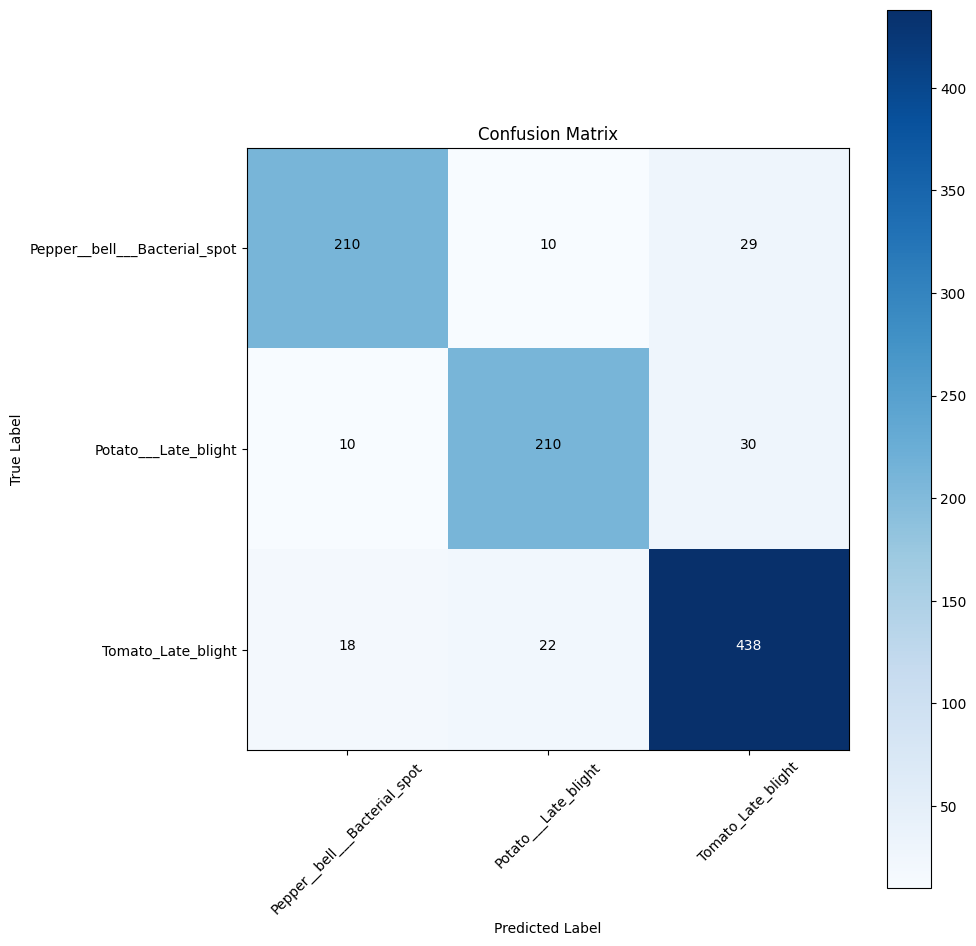

In [11]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], 
             horizontalalignment='center', 
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

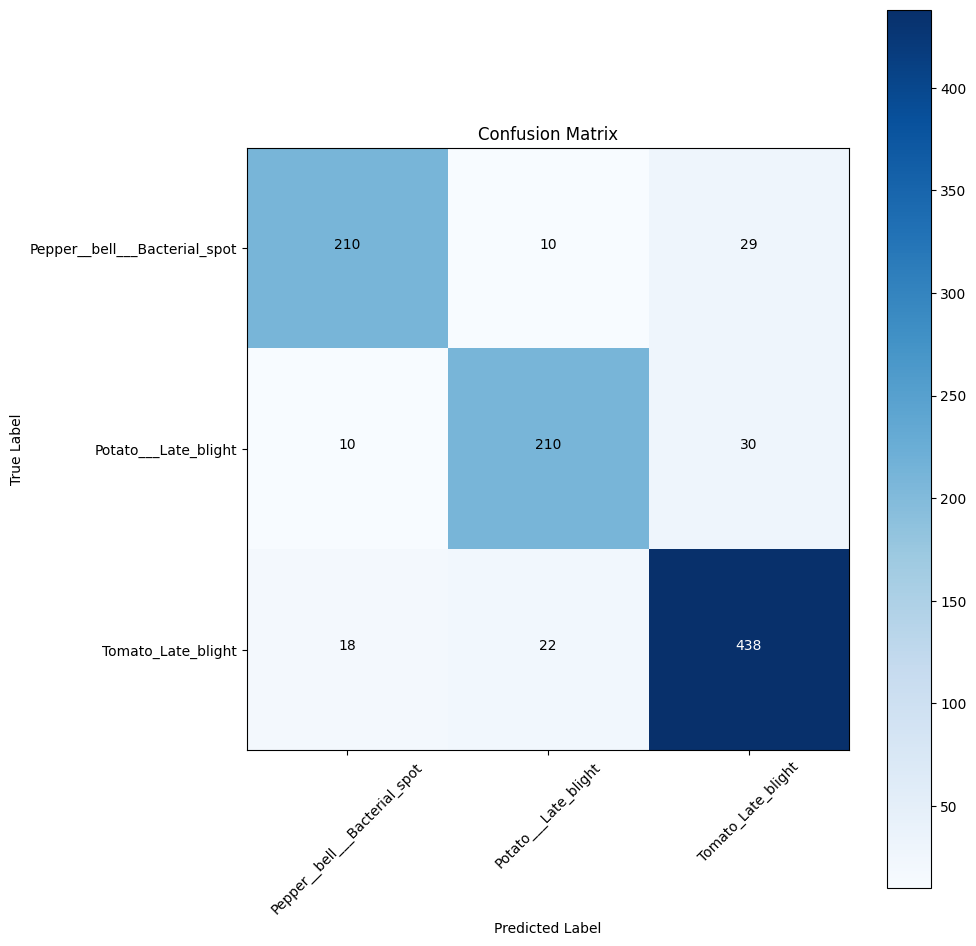

In [12]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], 
             horizontalalignment='center', 
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

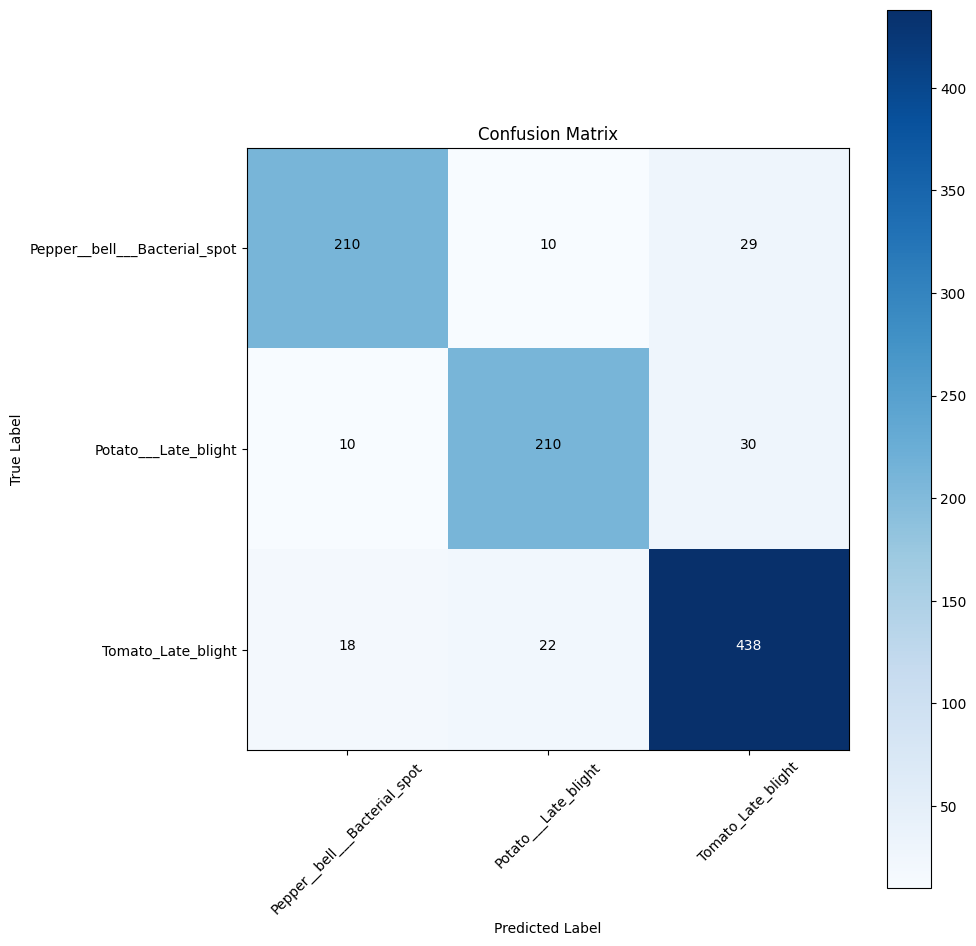

In [13]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], 
             horizontalalignment='center', 
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()